# Banking Project

***

>The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

>To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

> _ - in Banking Case Description, ECAC Moodle Page_

***

[Kaggle Challenge Page](https://www.kaggle.com/)

The steps performed are as follows:
* Data Loading and Preparation
* Descriptive Data Mining & Feature Engineering
* Predictive Data Mining

## Tools

For this work we will use the common tools in a data scientist and engineer arsenal. All of them work together in a seamless fashion, as well as with the Jupyter Notebook (this enhanced interactive document).

* **Numpy** is the fundamental package for scientific computing with Python
* **Pandas** provides high-performance, easy-to-use data structures (_e.g._ data frames) and data analysis tools
* **Matplotlib** implements plotting functionality
* **Scikit Learn** aggregates advanced machine learning tools

In [354]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn

plt.style.use('ggplot')
%matplotlib inline

## 1. Data Loading and Preparation

A key initial step in every data mining work is to prepare the data. This reduces the occurence of future unexpected behaviors and gives a preliminary insight over the "raw" data.

The **transactions** records describe transactions on accounts, representing dynamic characteristics of the accounts.

In [355]:
transactions_df = pd.read_csv('./data/banking - transaction.csv', 
                              sep=';',
                              parse_dates=['date'],
                              infer_datetime_format=True,
                              dtype={'bank':np.str},
                              index_col='trans_id')

In [356]:
transactions_df.head()

,account_id,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,
695247,2378,1993-01-01,credit,credit in cash,700,700,NaN,NaN,NaN
171812,576,1993-01-01,credit,credit in cash,900,900,NaN,NaN,NaN
207264,704,1993-01-01,credit,credit in cash,1000,1000,NaN,NaN,NaN
1117247,3818,1993-01-01,credit,credit in cash,600,600,NaN,NaN,NaN
579373,1972,1993-01-02,credit,credit in cash,400,400,NaN,NaN,NaN


**k_symbol** name is not very represent representative.

In [357]:
transactions_df = transactions_df.rename(columns={
    'k_symbol': 'trans_char'
    })

In [358]:
transactions_df.head()

,account_id,date,type,operation,amount,balance,trans_char,bank,account
trans_id,,,,,,,,,
695247,2378,1993-01-01,credit,credit in cash,700,700,NaN,NaN,NaN
171812,576,1993-01-01,credit,credit in cash,900,900,NaN,NaN,NaN
207264,704,1993-01-01,credit,credit in cash,1000,1000,NaN,NaN,NaN
1117247,3818,1993-01-01,credit,credit in cash,600,600,NaN,NaN,NaN
579373,1972,1993-01-02,credit,credit in cash,400,400,NaN,NaN,NaN


The **accounts** records contain static characteristics of the accounts.

In [359]:
accounts_df = pd.read_excel('./data/banking.xlsx', 
                            sheetname='account',
                            parse_dates=['date'],
                            infer_datetime_format=True,
                            index_col='account_id'
                           )

In [360]:
accounts_df.head()

,district_id,frequency,date
account_id,,,
576,55,monthly issuance,1993-01-01
3818,74,monthly issuance,1993-01-01
704,55,monthly issuance,1993-01-01
2378,16,monthly issuance,1993-01-01
2632,24,monthly issuance,1993-01-02


The **clients** records describe static characteristics of the clients.

In [361]:
clients_df = pd.read_excel('./data/banking.xlsx',
                           sheetname='client',
                           index_col='client_id')

In [362]:
clients_df.head()

,birth_number,district_id
client_id,,
1,706213,18
2,450204,1
3,406009,1
4,561201,5
5,605703,5


The **birth_number** feature is not readable in this representation. We have, then, to parse it and transform it into two new columns: **birthday** and **gender**.

In [363]:
clients_df['gender'] = clients_df.apply(lambda c: 'Male' if c['birth_number'] % 10000 < 5000 else 'Female', axis=1)

In [364]:
from datetime import date

def normalize_birth_number(client):
    birth_number = int(client['birth_number'])
    year = birth_number // 10000
    month = (birth_number // 100) % 100
    day = birth_number % 100
    
    month = month if month < 50 else month - 50
    
    return  "{0:02d}{1:02d}{2:02d}".format(year, month, day)


clients_df['birth_number'] = clients_df.apply(normalize_birth_number, axis=1) # month - 50 on females
clients_df['birthday'] = pd.to_datetime(clients_df['birth_number'], format='%y%m%d')
clients_df['birthday'] = clients_df.apply(
    lambda c: c['birthday'] if c['birthday'].date() <= date.today() else (c['birthday'] - pd.tseries.offsets.DateOffset(years=100)), 
    axis=1) # if infered year > 2015 the it is in the 19's
clients_df = clients_df.drop('birth_number', axis=1)

In [365]:
clients_df.head()

,district_id,gender,birthday
client_id,,,
1,18,Female,1970-12-13
2,1,Male,1945-02-04
3,1,Female,1940-10-09
4,5,Male,1956-12-01
5,5,Female,1960-07-03


The **dispositions** records relate a client with an account (being useful in join operations).

In [366]:
dispositions_df = pd.read_excel('./data/banking.xlsx',
                                sheetname='disposition',
                                index_col='disp_id')

In [367]:
dispositions_df.head()

,client_id,account_id,type
disp_id,,,
1,1,1,OWNER
2,2,2,OWNER
3,3,2,DISPONENT
4,4,3,OWNER
5,5,3,DISPONENT


The **payment_orders** records, like **transaction** records, represent another dynamic characteristic of accounts.

In [368]:
payment_orders_df = pd.read_excel('./data/banking.xlsx',
                                  sheetname='payment order',
                                  index_col='order_id')

In [369]:
payment_orders_df.head()

,account_id,bank_to,account_to,amount,k_symbol
order_id,,,,,
29401,1,YZ,87144583,2452.0,household
29402,2,ST,89597016,3372.7,loan
29403,2,QR,13943797,7266.0,household
29404,3,WX,83084338,1135.0,household
29405,3,CD,24485939,327.0,NaN


The **loans** records describe information of a loan for an account.

In [370]:
loans_df = pd.read_excel('./data/banking.xlsx',
                         sheetname='loan',
                         parse_dates=['date'],
                         infer_datetime_format=True,
                         index_col='loan_id')

In [371]:
loans_df.head()

,account_id,date,amount,duration,payments,status
loan_id,,,,,,
5314,1787,1993-07-05,96396,12,8033,B
5316,1801,1993-07-11,165960,36,4610,A
6863,9188,1993-07-28,127080,60,2118,A
5325,1843,1993-08-03,105804,36,2939,A
7240,11013,1993-09-06,274740,60,4579,A


The **credit_cards** records describes static information of a credit card.

In [372]:
credit_cards_df = pd.read_excel('./data/banking.xlsx',
                                sheetname='credit card',
                                parse_dates=['issued'],
                                infer_datetime_format=True,
                                index_col='card_id')

In [373]:
credit_cards_df.head()

,disp_id,type,issued
card_id,,,
1005,9285,classic,1993-11-07
104,588,classic,1994-01-19
747,4915,classic,1994-02-05
70,439,classic,1994-02-08
577,3687,classic,1994-02-15


The **districts** records provide demographic information about a district.

In [374]:
districts_df = pd.read_excel('./data/banking.xlsx',
                             sheetname='district',
                             index_col='A1')

In [375]:
districts_df.head()

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
A1,,,,,,,,,,,,,,,
1,D1,R1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,D2,R2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
3,D3,R2,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
4,D4,R2,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
5,D5,R2,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


The column labels provided lack any useful information.

In [376]:
districts_df = districts_df.rename(columns={
        'A2': 'district_name',
        'A3': 'region',
        'A4': 'no_inhabitants',
        'A5': 'no_municipalities_w_inhabitants_<499',
        'A6': 'no_municipalities_w_inhabitants_500-1999',
        'A7': 'no_municipalities_w_inhabitants_2000-9999',
        'A8': 'no_municipalities_w_inhabitants_>10000',
        'A9': 'no_cities',
        'A10': 'ratio_urban_inhabitants',
        'A11': 'average_salary',
        'A12': 'unemployment_rate_95',
        'A13': 'unemployment_rate_96',
        'A14': 'no_enterpreneurs_per_1000_inhabitants',
        'A15': 'no_commited_crimes_95',
        'A16': 'no_commited_crimes_96',
    })

districts_df.index.name = 'district_id'

In [377]:
districts_df.head()

,district_name,region,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
district_id,,,,,,,,,,,,,,,
1,D1,R1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,D2,R2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
3,D3,R2,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
4,D4,R2,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
5,D5,R2,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


Lets check if the types infered by Pandas library are correct:

In [378]:
districts_df.dtypes

district_name                                 object
region                                        object
no_inhabitants                                 int64
no_municipalities_w_inhabitants_<499           int64
no_municipalities_w_inhabitants_500-1999       int64
no_municipalities_w_inhabitants_2000-9999      int64
no_municipalities_w_inhabitants_>10000         int64
no_cities                                      int64
ratio_urban_inhabitants                      float64
average_salary                                 int64
unemployment_rate_95                          object
unemployment_rate_96                         float64
no_enterpreneurs_per_1000_inhabitants          int64
no_commited_crimes_95                         object
no_commited_crimes_96                          int64
dtype: object

We see that **unemployment_rate_95** and **no_commited_crimes_95** are loaded as objects.

In [379]:
districts_df['unemployment_rate_95'].unique()

array(['0.29', '1.67', '1.95', '4.64', '3.85', '2.95', '2.26', '1.25',
       '3.39', '0.56', '0.45', '3.83', '2.77', '1.42', '3.13', '1.12',
       '2.38', '2.83', '2.65', '1.51', '1.10', '1.79', '1.39', '2.47',
       '2.64', '0.65', '1.62', '2.82', '3.38', '3.52', '2.80', '5.75',
       '6.43', '1.02', '3.33', '4.46', '7.08', '7.34', '6.49', '3.32',
       '2.41', '1.72', '2.79', '2.28', '1.78', '1.89', '4.83', '2.51',
       '2.52', '2.53', '1.60', '1.88', '4.69', '3.73', '3.24', '3.45',
       '4.76', '1.29', '3.79', '5.74', '3.51', '5.77', '4.09', '?', '6.63',
       '5.93', '3.80', '4.75', '5.38', '4.73', '4.01'], dtype=object)

In [380]:
districts_df['no_commited_crimes_95'].unique()

array([85677, 2159, 2824, 5244, 2616, 2640, 4289, 5179, 2987, 3810, 3475,
       3804, 1597, 6604, 1845, 1874, 1003, 1740, 999, 1563, 2299, 1089,
       2879, 5198, 1822, 6041, 1029, 1580, 818, 2985, 1328, 4340, 4650,
       5323, 3384, 5796, 4147, 2653, 4947, 6949, 6445, 1658, 4085, 2166,
       2080, 2854, 6079, 1655, 1660, 2123, 3496, 2564, 1850, 18721, 3659,
       3729, 2212, 2595, 1879, 2112, 2719, 1562, 4484, 2157, 2247, 3244,
       5623, '?', 9878, 4980, 9672, 4355, 18782, 4063, 3736, 3460], dtype=object)

We see that both use a question mark to demark missing values. We'll convert properly those columns:

In [381]:
districts_df['unemployment_rate_95'] = pd.to_numeric(districts_df['unemployment_rate_95'], errors='coerce')
districts_df['no_commited_crimes_95'] = pd.to_numeric(districts_df['no_commited_crimes_95'], errors='coerce')

districts_df.dtypes

district_name                                 object
region                                        object
no_inhabitants                                 int64
no_municipalities_w_inhabitants_<499           int64
no_municipalities_w_inhabitants_500-1999       int64
no_municipalities_w_inhabitants_2000-9999      int64
no_municipalities_w_inhabitants_>10000         int64
no_cities                                      int64
ratio_urban_inhabitants                      float64
average_salary                                 int64
unemployment_rate_95                         float64
unemployment_rate_96                         float64
no_enterpreneurs_per_1000_inhabitants          int64
no_commited_crimes_95                        float64
no_commited_crimes_96                          int64
dtype: object

## 2. Descriptive Data Mining & Feature Engineering

This first section aims at providing ways to better understand and extract value from the data. This is mostly accoplished by gathering descriptive statistics and ploting.

Considering this gathered knowledge, the datasets are edited and joined into useful intermediate format, which represent the main entities in the data, and then in a format in which the machine learning algorithms are able to understand (most of the times a single matrix, and most of the times without missing values).

The **loans** relate to the remainder entities through the **account** they are linked to. Therefore, the remainder entities should be summarized in such a way that each of the **accounts** information is given in a single row.

### Loans Dataframe

We must look first to the loans because we will use the granting date of the loan to select which information is used to summarize the transactions.

In [382]:
loans_df.describe(include='all')

,account_id,date,amount,duration,payments,status
count,682.000000,682,682.000000,682.000000,682.000000,682
unique,NaN,559,NaN,NaN,NaN,4
top,NaN,1998-07-12 00:00:00,NaN,NaN,NaN,C
freq,NaN,4,NaN,NaN,NaN,403
first,NaN,1993-07-05 00:00:00,NaN,NaN,NaN,NaN
last,NaN,1998-12-08 00:00:00,NaN,NaN,NaN,NaN
mean,5824.162757,NaN,151410.175953,36.492669,4190.664223,NaN
std,3283.512681,NaN,113372.406310,17.075219,2215.830344,NaN
min,2.000000,NaN,4980.000000,12.000000,304.000000,NaN
25%,2967.000000,NaN,66732.000000,24.000000,2477.000000,NaN


In [383]:
print(loans_df.status.unique())

['B' 'A' 'C' 'D']


For reference:
 * **A-** contract finished, no problems
 * **B-** contract finished, loan not payed
 * **C-** running contract, ok so far
 * **D-** running contract, client in debt
 
Lets  see how the loans distribute accross the four categories:

In [384]:
loans_df.groupby('status').count()['account_id']

status
A    203
B     31
C    403
D     45
Name: account_id, dtype: int64

There are also a lot of contracts running, but most importantly there is a gret disparity between the two counts of the different loans results. We must be aware of this when training the algorithms. As we want to identify properly the loans that will have the **B** status, we have to be carefull when structuring the training and testing datasets.

In order to summarize this data, we want to obtain the *count* of loans in each state, as well as the *average* and *standard deviation* of the amount and duration associated with each loan.

In [385]:
def summarize_loans(df):
    summaries_dfs = []
    for tp in df['status'].unique():
        tmp_df = df[df['status'] == tp].drop('status', axis=1)
        
        tmp_grp_df = tmp_df.groupby('account_id').agg([np.count_nonzero, np.average, np.std])
        
        amount_df = tmp_grp_df['amount']
        amount_df = amount_df.rename(columns={'count_nonzero': tp + '_cnt',
                                           'average': tp + '_amount_avg',
                                           'std': tp + '_amount_std',
                                          })
        
        duration_df = tmp_grp_df['duration']
        duration_df = duration_df.drop('count_nonzero', axis='columns')
        duration_df = duration_df.rename(columns={'average': tp + '_duration_avg',
                                                  'std': tp + '_duration_std',
                                                 })
        joined_summary_df = amount_df.join(duration_df)
        summaries_dfs.append(joined_summary_df)
    
    # now concatenate the summaries_dfs
    summaries_df = pd.concat(summaries_dfs, axis='columns')
    return summaries_df


loans_summary_df = summarize_loans(loans_df)
loans_summary_df = loans_summary_df.fillna(0)
loans_summary_df.head()

,B_cnt,B_amount_avg,B_amount_std,B_duration_avg,B_duration_std,A_cnt,A_amount_avg,A_amount_std,A_duration_avg,A_duration_std,C_cnt,C_amount_avg,C_amount_std,C_duration_avg,C_duration_std,D_cnt,D_amount_avg,D_amount_std,D_duration_avg,D_duration_std
account_id,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,1,80952,0,24,0,0,0,0,0,0,0,0,0,0,0
19,1,30276,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,1,30276,0,12,0,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,318480,0,60,0
38,0,0,0,0,0,0,0,0,0,0,1,110736,0,48,0,0,0,0,0,0


Lets analyse if the history of each account is long enough to be used:

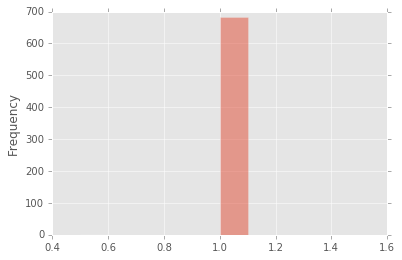

In [386]:
loans_hist_df = loans_summary_df[['A_cnt', 'B_cnt', 'C_cnt', 'D_cnt']].sum(axis='columns')
loans_hist_df.plot(kind='hist', alpha=0.5)

It seems that there are no accounts with more than one loan through time. Therefore, we will not use the loans history of each account.

### Transactions Dataframe

As we analyse the transactions dataframe, we must be careful to associate to each loan only the information about transactions that happened before the loan is granted, as future operations may be strictly correlated with the loan status, and we can't use them to train our models.

In [387]:
transactions_df.describe(include='all')

,account_id,date,type,operation,amount,balance,trans_char,bank,account
count,1056320.000000,1056320,1056320,873206,1056320.000000,1056320.000000,574439,273508,295389.000000
unique,NaN,2191,3,5,NaN,NaN,8,13,NaN
top,NaN,1998-06-30 00:00:00,withdrawal,withdrawal in cash,NaN,NaN,interest credited,QR,NaN
freq,NaN,9269,634571,434918,NaN,NaN,183114,22285,NaN
first,NaN,1993-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,1998-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2936.867290,NaN,NaN,NaN,5924.145676,38518.330803,NaN,NaN,45670919.374916
std,2477.345127,NaN,NaN,NaN,9522.735373,22117.868013,NaN,NaN,30663396.851208
min,1.000000,NaN,NaN,NaN,0.000000,-41125.700000,NaN,NaN,0.000000
25%,1204.000000,NaN,NaN,NaN,135.900000,22402.500000,NaN,NaN,17828584.000000


**type**, **operation** and **trans_char** seem all to represent the same information. Lets evaluate that:

In [388]:
print("type:", transactions_df['type'].unique())

type: ['credit' 'withdrawal' 'withdrawal in cash']


In [389]:
print("operation:", transactions_df['operation'].unique())

operation: ['credit in cash' 'collection from another bank' 'withdrawal in cash' nan
 'remittance to another bank' 'credit card withdrawal']


In [390]:
print("trans_char:", transactions_df['trans_char'].unique())

trans_char: [nan 'pension' 'interest credited' 'household' 'statement' ' '
 'insurance payment' 'sanction for negative balance' 'loan payment']


**operation** seems irrelevant given **type**:

In [391]:
transactions_df_e = transactions_df.drop('operation', axis=1).copy() # 'e' for edited

Its also irrelevant the distinction between *withrawal* and *withrawal in cash*.

In [392]:
mask = transactions_df_e['type'] == 'withdrawal in cash'
transactions_df_e.ix[mask, 'type'] = ('withdrawal')

We will create an additional column to store the signed amount (given by the type of operation), and another with the normalized **signed_amount** value, according to the **balance** previous to the operation (if an operation is the first one, we store 0):

In [393]:
transactions_df_e['signed_amount'] = transactions_df_e.apply(lambda x: - x['amount'] if x['type'] == 'withdrawal' else x['amount'], axis=1)
transactions_df_e['norm_signed_amount'] = transactions_df_e.apply(lambda x: 
                                                                      0 if (x['balance'] - x['signed_amount']) == 0 
                                                                      else x['signed_amount'] / (x['balance'] - x['signed_amount']), 
                                                                  axis=1)

We will build a function that outputs a summary of the transactions dataframe (if date or account are provided, uses information until a given date for a given account), regarding the following aspects:

 * From **trans_char** we are able to extract if the user is pensionist, or if the user has been sanctioned for negative balance, among other things. We will create an additional table with that information, with the values weighted by the **amount**, indexed by **account_id**.

 * The **balance** statistics may be relevant to compare with the loan amount, so we'll gather the *min*, *max*, *average* and *standard deviation*.
 
 * Regarding **normalized signed amount** and **type** of each operation, we will extract, for each **account**, the *count*, *mean* and *standard deviation* of operation values, as well as *mean* and *standard deviation* of the number of days between each **operation**, grouped by operation **type**.

In [394]:
transactions_df_e.head()

,account_id,date,type,amount,balance,trans_char,bank,account,signed_amount,norm_signed_amount
trans_id,,,,,,,,,,
695247,2378,1993-01-01,credit,700,700,NaN,NaN,NaN,700,0
171812,576,1993-01-01,credit,900,900,NaN,NaN,NaN,900,0
207264,704,1993-01-01,credit,1000,1000,NaN,NaN,NaN,1000,0
1117247,3818,1993-01-01,credit,600,600,NaN,NaN,NaN,600,0
579373,1972,1993-01-02,credit,400,400,NaN,NaN,NaN,400,0


In [395]:
def summarize_all_transactions(raw_trans_df, account=None, max_date=None):
    
    trans_df = raw_trans_df.copy()
    
    #if client specified, filter
    if account != None:
        trans_df = trans_df[trans_df.account_id == account]
    
    #if max_date specified, filter
    if max_date != None:
        trans_df = trans_df[trans_df.date < max_date]
    
    # remove the rows where an empty string is present
    mask = trans_df.trans_char != ' '
    transactions_df_e = trans_df.ix[mask]

    # select the needed rows from transactions_df
    trans_temp_df = trans_df[['account_id', 'trans_char', 'norm_signed_amount']].copy()

    # remove the rows containing NaN
    trans_temp_df = trans_temp_df.dropna(axis='index')
    trans_temp_df = trans_temp_df[trans_temp_df.trans_char != ' ']
    
    # create the dataframe indexed by account_id
    accounts_features_df = trans_temp_df[['account_id']].drop_duplicates(subset=['account_id'])
    accounts_features_df = accounts_features_df.set_index('account_id')

    # create the count columns, corresponding to the data countained in
        # pension
        # interest credited
        # household
        # statement
        # insurance payment
        # sanction for negative balance
        # loan payment

    def create_trans_count_col(df, val):
        new_df = df.ix[df['trans_char'] == val].groupby('account_id').sum()
        new_df = new_df.rename(columns={'norm_signed_amount':val})
        return new_df

    additional_dfs = [create_trans_count_col(trans_temp_df, val) for val in trans_temp_df['trans_char'].unique()]
    
    if accounts_features_df.empty:
        if len(additional_dfs) == 1:
            accounts_features_df = additional_dfs[0]
        elif len(additional_dfs) > 1:
            accounts_features_df = additional_dfs[0].join(additional_dfs[1:])
    else:
        accounts_features_df = accounts_features_df.join(additional_dfs)
    
    temp_df = trans_df[['account_id', 'balance']].copy()

    balances_summary_df = temp_df.groupby('account_id').agg([np.max, np.min, np.average, np.std])['balance']
    balances_summary_df = balances_summary_df.rename(columns={'amax': 'balance_max',
                                                              'amin': 'balance_min',
                                                              'average': 'balance_avg',
                                                              'std': 'balance_std'})
    if accounts_features_df.empty:
        accounts_features_df = balances_summary_df
    else:
        accounts_features_df = accounts_features_df.join(balances_summary_df)
    
    temp_df = trans_df[['account_id', 'type', 'norm_signed_amount', 'date']].copy()
    
    # sort firstly by account_id, then by date
    temp_df = temp_df.sort_values(by=['account_id', 'date'])

    #obtain, by row, the previous date
    if account != None:
        prev_dates = temp_df['date'].shift().fillna(temp_df.iloc[0]['date'])
    else:
        prev_dates = temp_df.groupby('account_id').apply(lambda x: x['date'].shift().fillna(x.iloc[0]['date'])) \
        .reset_index(level=0)['date']
    
    delta = temp_df['date'] - prev_dates
    delta = delta.astype("timedelta64[D]")
    temp_df['date_delta'] = delta
    
    def summarize_transactions(df):
        summaries_dfs = []
        for tp in df['type'].unique():
            tmp_df = temp_df[temp_df['type'] == tp].drop('type', axis=1)

            tmp_grp_df = tmp_df.groupby('account_id').agg([np.count_nonzero, np.average, np.std])
            tmp_grp_df.fillna(0)

            ops_df = tmp_grp_df['norm_signed_amount']
            ops_df = ops_df.rename(columns={'count_nonzero': tp + '_cnt',
                                            'average': tp + '_avg',
                                            'std': tp + '_std',
                                           })

            dates_df = tmp_grp_df['date_delta']
            dates_df = dates_df.drop('count_nonzero', axis='columns')
            dates_df = dates_df.rename(columns={'average': tp + '_dates_avg',
                                                'std': tp + '_dates_std',
                                               })
            joined_summary_df = ops_df.join(dates_df)
            summaries_dfs.append(joined_summary_df)

        # now concatenate the summaries_dfs
        summaries_df = pd.concat(summaries_dfs, axis='columns')
        return summaries_df

    trans_summaries_df = summarize_transactions(temp_df)
    
    if accounts_features_df.empty:
        accounts_features_df = trans_summaries_df
    else:
        accounts_features_df = accounts_features_df.join(trans_summaries_df)
    
    return accounts_features_df

In [396]:
trans_features = summarize_all_transactions(transactions_df_e)
trans_features.head()

,pension,interest credited,household,statement,insurance payment,sanction for negative balance,loan payment,balance_max,balance_min,balance_avg,...,credit_cnt,credit_avg,credit_std,credit_dates_avg,credit_dates_std,withdrawal_cnt,withdrawal_avg,withdrawal_std,withdrawal_dates_avg,withdrawal_dates_std
account_id,,,,,,,,,,,,,,,,,,,,,
4,17.641229,0.125462,-2.917712,-0.020211,NaN,NaN,NaN,34870.0,800,21753.446237,...,64,0.273334,0.859505,4.523077,7.644663,121,-0.059758,0.046077,6.198347,5.580651
5,13.342219,0.059509,-1.449807,-0.007832,NaN,NaN,NaN,32036.2,600,25090.069048,...,34,0.382907,1.399983,5.971429,9.447956,49,-0.052975,0.047930,7.571429,4.082483
6,19.061606,0.196014,-4.866938,-0.020693,NaN,NaN,NaN,51878.9,900,34547.349187,...,98,0.194521,0.745481,5.707071,7.243931,147,-0.055649,0.054151,6.741497,6.708294
12,12.778797,0.073643,-0.267233,-0.010551,NaN,NaN,NaN,29053.0,1100,20142.701887,...,38,0.329550,0.860090,4.358974,8.922140,67,-0.067113,0.078127,6.791045,5.144981
13,15.600257,0.060332,-1.994121,-0.011899,NaN,NaN,NaN,29750.6,1000,15120.500000,...,30,0.505180,1.209745,5.354839,8.811161,44,-0.127461,0.112124,7.613636,6.012452


Now merge with **loans** dataframe, but for each row obtain just the summary for the transactions that happened before the loan granting:

In [397]:
temp_dfs = []
for i, row in loans_df.iterrows():
    temp_df = summarize_all_transactions(transactions_df_e, row['account_id'], row['date'])
    temp_dfs.append(temp_df)
    #loans_transactions_df = loans_transactions_df.merge(temp_df, left_on='account_id', right_index=True, how='left', sort=False)
    
loans_transactions_df = pd.concat(temp_dfs)
loans_transactions_df = loans_transactions_df.fillna(0)
loans_transactions_df = loans_transactions_df.merge(loans_df, right_on='account_id', left_index=True, how='left', sort=False)
loans_transactions_df.head()

,balance_avg,balance_max,balance_min,balance_std,credit_avg,credit_cnt,credit_dates_avg,credit_dates_std,credit_std,household,...,withdrawal_cnt,withdrawal_dates_avg,withdrawal_dates_std,withdrawal_std,account_id,date,amount,duration,payments,status
loan_id,,,,,,,,,,,,,,,,,,,,,
5314,12250.000000,20100.0,1100,8330.866301,2.430925,3,22.500000,15.000000,4.384785,0.000000,...,0,0.000000,0.000000,0.000000,1787,1993-07-05,96396,12,8033,B
5316,52083.859459,120512.8,700,29122.059454,1.888075,16,5.705882,4.934125,6.478889,-0.188938,...,20,2.450000,2.625282,0.141195,1801,1993-07-11,165960,36,4610,A
6863,30060.954167,49590.4,800,11520.184451,1.224438,14,9.133333,10.294705,4.064382,-0.166444,...,9,2.888889,3.059593,0.131191,9188,1993-07-28,127080,60,2118,A
5325,41297.480000,65898.5,1000,14151.260443,1.599446,12,8.846154,8.532742,4.825893,-0.233710,...,12,5.583333,6.639528,0.100542,1843,1993-08-03,105804,36,2939,A
7240,57188.211111,122893.1,600,25256.665817,5.784333,12,9.846154,8.839741,19.422572,-0.017927,...,14,5.000000,5.449065,0.136008,11013,1993-09-06,274740,60,4579,A


### Clients

Now we'll take a look at the features that characterize each user.

In [398]:
clients_df.describe(include='all')

,district_id,gender,birthday
count,5369.000000,5369,5369
unique,NaN,2,4738
top,NaN,Male,1952-08-26 00:00:00
freq,NaN,2724,4
first,NaN,NaN,1916-01-20 00:00:00
last,NaN,NaN,2015-09-27 00:00:00
mean,37.310114,NaN,NaN
std,25.043690,NaN,NaN
min,1.000000,NaN,NaN
25%,14.000000,NaN,NaN


As for each user corresponds a district, we'll look into the corresponding table:

In [399]:
districts_df.describe(include='all')

,district_name,region,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
count,77,77,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,76.000000,77.000000,77.000000,76.000000,77.000000
unique,77,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,D43,R7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,133884.896104,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.119342,3.787013,116.129870,4850.315789,5030.831169
std,NaN,NaN,136913.464909,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.665568,1.908480,16.608773,9888.951933,11270.796786
min,NaN,NaN,42821.000000,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000
25%,NaN,NaN,85852.000000,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,1.787500,2.310000,105.000000,2029.750000,2122.000000
50%,NaN,NaN,108871.000000,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,2.825000,3.600000,113.000000,2932.000000,3040.000000
75%,NaN,NaN,139012.000000,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,3.890000,4.790000,126.000000,4525.500000,4595.000000


We can consider both the individual districts or the regions. 
In order to evaluate if the generalization for regions is reduces or not some interesting events, we'll use PCA to reduce the dimensionality of the table to two dimensions, therefore making it possible to plot.

In [446]:
districts_df_e = districts_df.drop(['district_name', 'region'], axis='columns')
districts_df_e = districts_df_e.fillna(0)

In [447]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
districts_reduced = pca.fit_transform(districts_df_e.values)

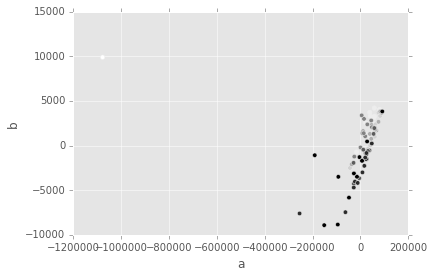

In [448]:
districts_df_e['a'] = districts_reduced[:, 0]
districts_df_e['b'] = districts_reduced[:, 1]

# convert regions to integers, to use them as colors
regions = districts_df.apply(lambda x: x['region'][1], axis='columns').astype(int)

districts_df_e.plot(kind='scatter', x='a', y='b', c=regions)

From the plot we conclude that probably it is beneficial to work with districts.

In [402]:
clients_df.head()

,district_id,gender,birthday
client_id,,,
1,18,Female,1970-12-13
2,1,Male,1945-02-04
3,1,Female,1940-10-09
4,5,Male,1956-12-01
5,5,Female,1960-07-03


In [403]:
clients_districts_df = pd.merge(clients_df, districts_df.drop(['region', 'district_name'], axis='columns'), left_on='district_id', right_index=True, how='left', sort=False)

# we no longer need district_id column
clients_districts_df = clients_districts_df.drop('district_id', axis='columns')

clients_districts_df.head()

,gender,birthday,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
client_id,,,,,,,,,,,,,,,
1,Female,1970-12-13,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
2,Male,1945-02-04,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
3,Female,1940-10-09,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
4,Male,1956-12-01,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
5,Female,1960-07-03,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


Now we'll merge **Credit Cards** and **Clients** information with the accounts.

As there may be multiple credit cards and clients associated with a given account, we have to devise a certain heuristics.

In [404]:
dispositions_df.describe(include='all')

,client_id,account_id,type
count,5369.000000,5369.000000,5369
unique,NaN,NaN,2
top,NaN,NaN,OWNER
freq,NaN,NaN,4500
mean,3359.011920,2767.496927,NaN
std,2832.911984,2307.843630,NaN
min,1.000000,1.000000,NaN
25%,1418.000000,1178.000000,NaN
50%,2839.000000,2349.000000,NaN
75%,4257.000000,3526.000000,NaN


In [405]:
dispositions_df.type.unique()

array(['OWNER', 'DISPONENT'], dtype=object)

To start, we'll simply use the information about the owner of the account.

We'll check the data if there is really only one owner per account.

In [406]:
dispositions_owners_df = dispositions_df[dispositions_df['type'] == 'OWNER'].drop('type', axis='columns')

In [407]:
owners_per_account_df = dispositions_owners_df.groupby(['account_id']).count()

owners_per_account_df[owners_per_account_df['client_id'] != 1].count(axis='index')

client_id    0
dtype: int64

We can now merge **clients** with **accounts**

In [408]:
accounts_disp_merge = accounts_df.merge(dispositions_owners_df, left_index=True, right_on='account_id', how='left', sort=False)
accounts_disp_merge = accounts_disp_merge.set_index('account_id')


accounts_clients_df = accounts_disp_merge.merge(clients_districts_df, left_on='client_id', right_index=True, how='left', sort=False)
accounts_clients_df = accounts_clients_df.drop('client_id', axis='columns')

accounts_clients_df = accounts_clients_df.fillna(0)

accounts_clients_df.head()

,district_id,frequency,date,gender,birthday,no_inhabitants,no_municipalities_w_inhabitants_<499,no_municipalities_w_inhabitants_500-1999,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
account_id,,,,,,,,,,,,,,,,,,
576,55,monthly issuance,1993-01-01,Female,1936-01-11,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
3818,74,monthly issuance,1993-01-01,Male,1935-04-02,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
704,55,monthly issuance,1993-01-01,Male,1945-01-14,58400,65,16,4,1,6,52.4,8620,1.10,1.25,100,1089,1117
2378,16,monthly issuance,1993-01-01,Female,1975-03-24,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874,1913
2632,24,monthly issuance,1993-01-02,Male,1938-08-12,122603,25,21,6,2,8,80.0,8991,1.39,2.01,128,5198,5273


Now we have to prepare a dataframe such that the machine-learning algorithms are able to undertand it. In order to accomplish that, we will merge this **accounts_loans_df** dataframe with the original **loans_df** dataframe. For new loans that arive, the process will be the same, therefore we want to encapsulate the process in a function:

In [441]:
accounts_final_df = accounts_clients_df.rename(columns={'date': 'date created'})
accounts_final_df['account_id'] = accounts_final_df.index

def join_loans_accounts(l_df):
    dataset = pd.merge(l_df, accounts_final_df, left_on='account_id', right_index=True, how='left', sort=False)
    dataset = dataset.drop(['account_id_x', 'account_id_y'], axis='columns')
    return dataset

dataset = join_loans_accounts(loans_transactions_df)

In [443]:
dataset.head()

,balance_avg,balance_max,balance_min,balance_std,credit_avg,credit_cnt,credit_dates_avg,credit_dates_std,credit_std,household,...,no_municipalities_w_inhabitants_2000-9999,no_municipalities_w_inhabitants_>10000,no_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_enterpreneurs_per_1000_inhabitants,no_commited_crimes_95,no_commited_crimes_96
loan_id,,,,,,,,,,,,,,,,,,,,,
5314,12250.000000,20100.0,1100,8330.866301,2.430925,3,22.500000,15.000000,4.384785,0.000000,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
5316,52083.859459,120512.8,700,29122.059454,1.888075,16,5.705882,4.934125,6.478889,-0.188938,...,7,3,10,73.5,8369,1.79,2.31,117,2854,2618
6863,30060.954167,49590.4,800,11520.184451,1.224438,14,9.133333,10.294705,4.064382,-0.166444,...,6,1,5,53.5,8390,2.28,2.89,132,2080,2122
5325,41297.480000,65898.5,1000,14151.260443,1.599446,12,8.846154,8.532742,4.825893,-0.233710,...,10,1,9,74.8,10045,1.42,1.71,135,6604,6295
7240,57188.211111,122893.1,600,25256.665817,5.784333,12,9.846154,8.839741,19.422572,-0.017927,...,5,1,5,50.5,8288,3.79,4.52,110,1562,1460


In [453]:
dataset.dtypes

balance_avg                                         float64
balance_max                                         float64
balance_min                                         float64
balance_std                                         float64
credit_avg                                          float64
credit_cnt                                          float64
credit_dates_avg                                    float64
credit_dates_std                                    float64
credit_std                                          float64
household                                           float64
insurance payment                                   float64
interest credited                                   float64
sanction for negative balance                       float64
statement                                           float64
withdrawal_avg                                      float64
withdrawal_cnt                                      float64
withdrawal_dates_avg                    

We just have now to convert the timestamp columns to an integer value. We'll use Unix time:

In [460]:
def convert_date_cols(df):
    new_df = df.copy()
    for col in new_df.columns:
        if new_df[col].dtype == 'datetime64[ns]':
            new_df[col] = new_df[col].astype(np.int64) // 10**9
    return new_df
            

dataset_valid = convert_date_cols(dataset)

and convert categorical data in new columns:

In [465]:
features_mask = dataset_valid.columns[dataset_valid.columns != 'status']

dataset_valid_num = pd.get_dummies(dataset_valid[features_mask])
dataset_valid_num['status'] = dataset_valid['status']

In [501]:
features = dataset_valid_num.columns[dataset_valid_num.columns != 'status']

## Clustering

In [530]:
from sklearn import metrics

def bench_clustering(estimator, name, data):
    sample_size = data.shape[0]
    estimator.fit(data)
    print('Name: %9s \
           \nHomogeineity: %.3f \
           \nCompleteness: %.3f \
           \nV_Measure: %.3f \
           \nAdjusted rand: %.3f \
           \nAdjusted mutual_info: %.3f \
           \nSilhoutette: %.3f'
          % (name,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [531]:
data = dataset_valid_num[features].values
reduced_data = PCA(n_components=2).fit_transform(data)

### KMeans

In [532]:
from sklearn.cluster import KMeans

bench_clustering(KMeans(n_clusters=2, init='k-means++', n_init=10), 'KMeans', data)

Name:    KMeans            
Homogeineity: 1.000            
Completeness: 1.000            
V_Measure: 1.000            
Adjusted rand: 1.000            
Adjusted mutual_info: 1.000            
Silhoutette: 0.588


In [533]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10)
labels = kmeans.fit_predict(reduced_data)

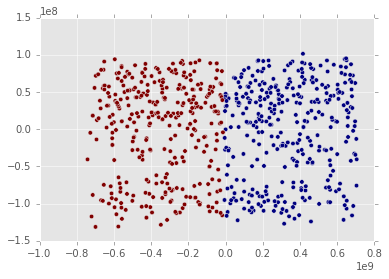

In [534]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)

### Affinity Propagation

In [535]:
from sklearn.cluster import AffinityPropagation

bench_clustering(AffinityPropagation(), 'AffinityPropagation', data)

Name: AffinityPropagation            
Homogeineity: 0.902            
Completeness: 0.219            
V_Measure: 0.352            
Adjusted rand: 0.104            
Adjusted mutual_info: 0.215            
Silhoutette: 0.371


In [536]:
affinity_prop = AffinityPropagation()
labels = affinity_prop.fit_predict(reduced_data)

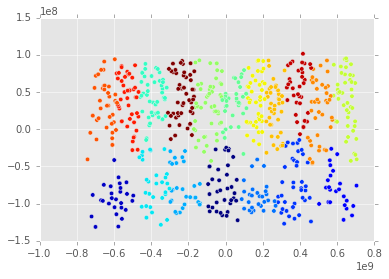

In [538]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)

### Mean shift

In [540]:
from sklearn.cluster import MeanShift

bench_clustering(MeanShift(), 'MeanShift', data)

Name: MeanShift            
Homogeineity: 0.225            
Completeness: 0.931            
V_Measure: 0.362            
Adjusted rand: 0.106            
Adjusted mutual_info: 0.221            
Silhoutette: 0.588


In [543]:
mean_shift = MeanShift()
labels = mean_shift.fit_predict(reduced_data)

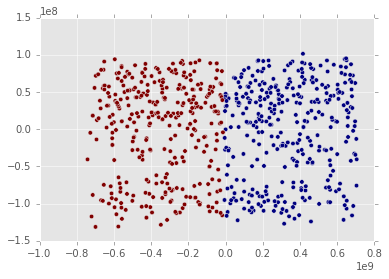

In [544]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)

### Agglomerative Clustering

In [548]:
from sklearn.cluster import AgglomerativeClustering

bench_clustering(AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete'), 'AgglomerativeClustering', data)

Name: AgglomerativeClustering            
Homogeineity: 0.570            
Completeness: 0.589            
V_Measure: 0.580            
Adjusted rand: 0.585            
Adjusted mutual_info: 0.570            
Silhoutette: 0.557


In [551]:
agglomerative = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
labels = agglomerative.fit_predict(reduced_data)

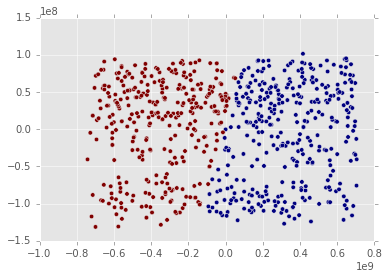

In [552]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)

## 3. Predictive Data Mining

We have to start by extracting the useful rows: the ones with **status** *A* and *B*:

In [456]:
def select_useful_rows(df):
    mask = (df.status == 'A') | (df.status == 'B')
    return df[mask]

In [457]:
dataset_valid_num = select_useful_rows(dataset_valid_num)

In [469]:
print(dataset.shape)
print(dataset_valid_num.shape)

(682, 42)
(682, 45)


In [470]:
features = dataset_valid_num.columns[dataset_valid_num.columns != 'status']
label = 'status'
target_names = ['A', 'B']

### Testing classifiers

We'll start off by using a **decision tree** as our first machine learning classifier. It has the benefits of working both with continuous and discrete data types, and provides a very natural way to interpret the results it gives.

We'll use stratified k-folds cross-validation to prevent overfitting.

The next function implements the procedure of, for a given model, it splits the data into train and test sets, and next performs stratified k-fold cross-validation to select an instance of the model that performs best for the corresponding validation set. It returns the score of the classifier in the testing set, as well as the confusion matrix.

In [418]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import clone as skl_clone
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def k_fold_model_select(data, features, label, raw_classifiers, n_folds=10, weigh_samples_fn=None): 
    # weigh_samples_fn is explained below
    # assumes that the raw_classifier output is in probability
    
    # split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(data[features].values, 
                                                        data[label].values,
                                                        test_size=0.3,
                                                        stratify=data[label],
                                                        random_state=0)
    
    
    # use stratified k-fold cross validation to select the model
    skf = StratifiedKFold(y_train, n_folds=n_folds)

    best_classifier = None
    best_score = float('-inf')

    for train_index, validation_index in skf:
        for raw_classifier in raw_classifiers:
            classifier = skl_clone(raw_classifier)
            classifier = classifier.fit(X_train[train_index], y_train[train_index])

            if weigh_samples_fn != None:
                y_pred = classifier.predict(X_train[validation_index])
                sample_weight = weigh_samples_fn(y_train[validation_index], y_pred)
            else:
                sample_weight = None

            score = classifier.score(X_train[validation_index], y_train[validation_index],
                                     sample_weight=sample_weight)

            if score > best_score:
                best_classifier = classifier
                best_score = score
    
    # compute the confusion matrix
    y_pred = best_classifier.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # now compute the score for the test data of the best found classifier
    if weigh_samples_fn != None:
        sample_weight = weigh_samples_fn(y_test, y_pred)
    else:
        sample_weight = None
    test_score = best_classifier.score(X_test, y_test, sample_weight=sample_weight)
    
    # obtain the classification report
    report = classification_report(y_test, y_pred, target_names=target_names, sample_weight=sample_weight)
    
    # obtain ROC curve
    y_test_bin = label_binarize(y_test, classes=target_names)
    y_prob = best_classifier.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_prob[:, 1])
    roc_info = (best_classifier.__class__.__name__, (fpr, tpr))
    
    return (test_score, report, conf_mat, roc_info, best_classifier)

In [419]:
from matplotlib.font_manager import FontProperties

def plot_roc_curves(roc_curves):
    for name, (fpr, tpr) in roc_curves:
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC for {} (area = {:0.2f})'.format(name, roc_auc))
        
    fontP = FontProperties()
    fontP.set_size('small')
    
    plt.legend(prop=fontP, bbox_to_anchor=(2.1, 1.05))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

Before proceding any further, we have to define how the accuracy is measured given this business situation; we have to measure them according to the way we are predicting it in comparison to the ground truth, *i.e.*, according to the position in the confusion matrix.

As such, we will use the following weights:
 * **True Positives:** 1
 * **False Negatives:** 2
 * **False Positives:** 1
 * **True Negatives:** 1
 
This is because we really want to prevent the cases where we label a user as not trustable, when in fact he is trustable, as he most likely will switch bank and kill all the future accumulated profits.

This weight is then multiplied by the inverse frequency of a given label in the samples, in order to weigh samples independently from the fact that the label counts are disparate.

In [420]:
def weigh_samples(y_true, y_pred):
    weights = []
    a_len = len(y_true[y_true == 'A'])
    b_len = len(y_true[y_true == 'B'])
    for s_true, s_pred in zip(y_true, y_pred):
        if s_true == 'A':
            if s_pred == 'B':
                weights.append(2 / a_len)
            else:
                weights.append(1 / a_len)
        else:
            weights.append(1 / b_len)
    return weights

In [421]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_split=20, random_state=0, class_weight='balanced')
dtc_score, dtc_rep, dtc_cm, dtc_roc, dtc_clf = k_fold_model_select(dataset_valid_num, features, label, [dtc], weigh_samples_fn=weigh_samples)

In [422]:
from sklearn.externals.six import StringIO
import pydot_ng as pydot
from IPython.display import Image

def display_tree(dtc_classifier):
    dot_data = StringIO()  
    tree.export_graphviz(dtc_classifier, out_file=dot_data,  
                         feature_names=features_mask,
                         class_names=target_names,
                         filled=True,
                         rounded=True,
                         special_characters=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

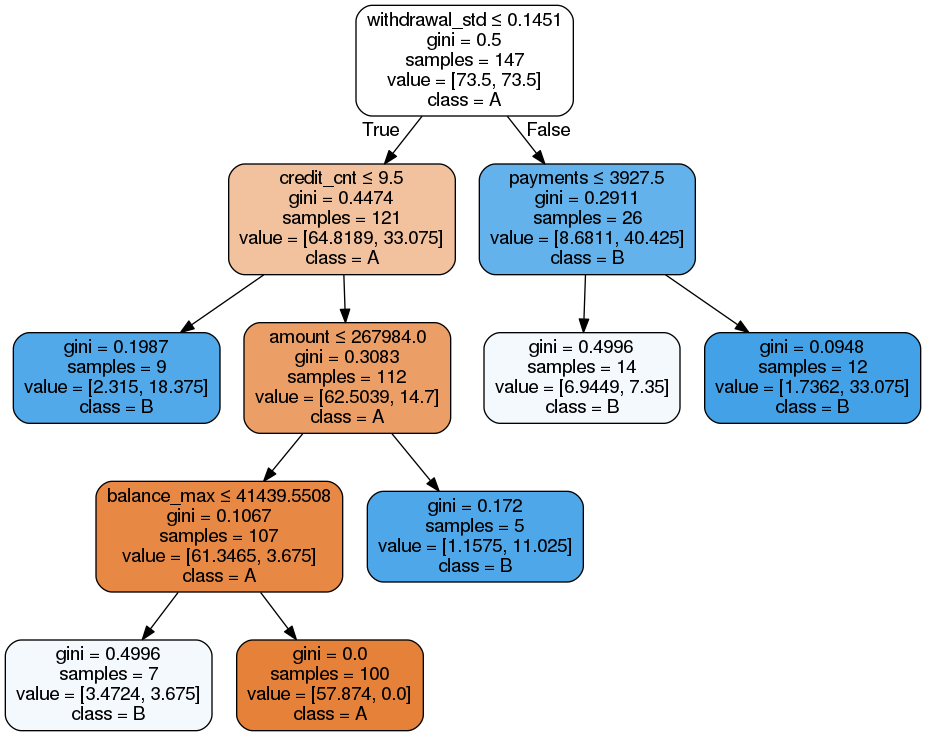

In [423]:
display_tree(dtc_clf)

Let's analyse more deeply these results. For that, we'll use the obtained score in predicting the test set and the confusion matrix:

In [424]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [425]:
def normalize_confusion_matrix(cm):
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized

Score for best Decision Tree Classifier: 0.629129129129
Confusion matrix:
[[38 24]
 [ 1  8]]
Classification report:
             precision    recall  f1-score   support

          A       0.85      0.44      0.58 1.3870967741935474
          B       0.53      0.89      0.67 1.0000000000000002

avg / total       0.72      0.63      0.62 2.3870967741935476



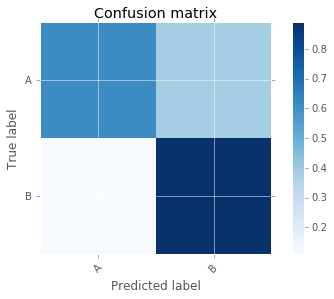

In [426]:
print("Score for best Decision Tree Classifier:", dtc_score)
print("Confusion matrix:", dtc_cm, sep='\n')
print("Classification report:", dtc_rep, sep='\n')

plot_confusion_matrix(normalize_confusion_matrix(dtc_cm))

Things seem prety good: we have a good accuracy, and the plotted confusion matrix shows high percentage of results in the main diagonal!

Nonetheless, there are two factors we have to take into account: 
 * As stated before, we have very few examples with label **B** (unsuccessful loans), and those events, despite unusual, are very costly. Therefore we need to give them higher relevance.
 * Trustworthy users that are labeled as trustless ones will most likely swithch to a different bank, negating all the future accumulated revenue. As shown by the confusion matrix, one of the users suffers from exactly this fenomena, therefore we must pay attention to that fact.

Because of this, we must be pragmatic about these results and perform some changes.

In order to gain more insight, we'll continue by testing other classifiers. 

Where applicable, we'll also set the weights given to each label to be **balanced**: this way the classifiers take into account the frequency of each class and automatically adjust their behavior.

In [427]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(min_samples_split=20, random_state=0, class_weight='balanced')
dt_score, dt_rep, dt_cm, dt_roc, dt_clf = k_fold_model_select(dataset_valid_num, features, label, [dt], weigh_samples_fn=weigh_samples)

print("Score:", dt_score)
print("Confusion matrix:", dt_cm, sep='\n')
print("Classification report:", dt_rep, sep='\n')

Score: 0.629129129129
Confusion matrix:
[[38 24]
 [ 1  8]]
Classification report:
             precision    recall  f1-score   support

          A       0.85      0.44      0.58 1.3870967741935474
          B       0.53      0.89      0.67 1.0000000000000002

avg / total       0.72      0.63      0.62 2.3870967741935476



In [428]:
# Linear Classifier (Logistic Regression)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr_score, lr_rep, lr_cm, lr_roc, lr_clf = k_fold_model_select(dataset_valid_num, features, label, [lr], weigh_samples_fn=weigh_samples)

print("Score:", lr_score)
print("Confusion matrix:", lr_cm, sep='\n')
print("Classification report:", lr_rep, sep='\n')

Score: 0.486810551559
Confusion matrix:
[[47 15]
 [ 6  3]]
Classification report:
             precision    recall  f1-score   support

          A       0.53      0.61      0.57 1.2419354838709669
          B       0.41      0.33      0.37 1.0000000000000002

avg / total       0.48      0.49      0.48 2.241935483870967



In [429]:
# Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(weights='distance')
knn_score, knn_rep, knn_cm, knn_roc, knn_clf = k_fold_model_select(dataset_valid_num, features, label, [knn], weigh_samples_fn=weigh_samples)

print("Score:", knn_score)
print("Confusion matrix:", knn_cm, sep='\n')
print("Classification report:", knn_rep, sep='\n')

Score: 0.530864197531
Confusion matrix:
[[60  2]
 [ 8  1]]
Classification report:
             precision    recall  f1-score   support

          A       0.52      0.94      0.67 1.0322580645161283
          B       0.63      0.11      0.19 1.0000000000000002

avg / total       0.58      0.53      0.43 2.0322580645161286



In [430]:
# (Gaussian Naive Bayes)
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb_score, nb_rep, nb_cm, nb_roc, nb_clf = k_fold_model_select(dataset_valid_num, features, label, [nb], weigh_samples_fn=weigh_samples)

print("Score:", nb_score)
print("Confusion matrix:", nb_cm, sep='\n')
print("Classification report:", nb_rep, sep='\n')

Score: 0.555555555556
Confusion matrix:
[[62  0]
 [ 8  1]]
Classification report:
             precision    recall  f1-score   support

          A       0.53      1.00      0.69 0.9999999999999992
          B       1.00      0.11      0.20 1.0000000000000002

avg / total       0.76      0.56      0.45 1.9999999999999996



In [431]:
# Neural Network (Multi-Layer Perceptron)
from sknn.mlp import Classifier as MLPClassifier
from sknn.mlp import Layer as MLPLayer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# use a pipeline that first normalizes the data

nn = MLPClassifier(
    layers=[
        MLPLayer("Maxout", units=30, pieces=2),
        MLPLayer("Softmax")],
    learning_rate=0.000000001,
    n_iter=25)

pipeline = Pipeline([
        ('min/max scaler', MinMaxScaler(feature_range=(0.0, 1.0))),
        ('neural network', nn)])

nn_score, nn_rep, nn_cm, nn_roc, nn_clf = k_fold_model_select(dataset_valid_num, features, label, [nn], 
                                                      weigh_samples_fn=weigh_samples)

print("Score:", nn_score)
print("Confusion matrix:", nn_cm, sep='\n')
print("Classification report:", nn_rep, sep='\n')

Score: 0.5
Confusion matrix:
[[62  0]
 [ 9  0]]
Classification report:
             precision    recall  f1-score   support

          A       0.50      1.00      0.67 0.9999999999999992
          B       0.00      0.00      0.00 1.0000000000000002

avg / total       0.25      0.50      0.33 1.9999999999999996



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We'll test SVC with different kernels.

In [432]:
# SVC (linear kernel)
from sklearn.svm import SVC

#svc_linear = SVC(kernel='linear')
#svc_linear_score, svc_linear_rep, svc_linear_cm, svc_linear_roc, svc_linear_clf = k_fold_model_select(dataset_valid_num, features, label, [svc_linear],
#                                                                        n_folds=2, weigh_samples_fn=weigh_samples)

#print("Score:", svc_linear_score)
#print("Confusion matrix:", svc_linear_cm, sep='\n')
#print("Classification report:", svc_linear_rep, sep='\n')

In [433]:
# SVC (sigmoid kernel)
from sklearn.svm import SVC

#svc_sigmoid = SVC(kernel='linear')
#svc_sigmoid_score, svc_sigmoid_rep, svc_sigmoid_cm, svc_sigmoid_roc, svc_sigmoid_clf = k_fold_model_select(dataset_valid_num, features, label, [svc_sigmoid],
#                                                                        n_folds=2, weigh_samples_fn=weigh_samples)

#print("Score:", svc_sigmoid_score)
#print("Confusion matrix:", svc_sigmoid_cm, sep='\n')
#print("Classification report:", svc_sigmoid_rep, sep='\n')

In [434]:
# SVC (radial basis function kernel)
from sklearn.svm import SVC

#svc_rbf = SVC(kernel='rbf')
#svc_rbf_score, svc_rbf_rep, svc_rbf_cm, svc_rbf_roc, svc_rbf_clf = k_fold_model_select(dataset_valid_num, features, label, [svc_rbf],
#                                                                        n_folds=2, weigh_samples_fn=weigh_samples)

#print("Score:", svc_rbf_score)
#print("Confusion matrix:", svc_sigmoid_cm, sep='\n')
#print("Classification report:", svc_sigmoid_rep, sep='\n')

Now we'll test some ensamble methods:

Starting by **AdaBoost**, this algorithm enables to, in each of its iterations, specialize a base classifier for the instances incorrectly classified in the previous iterations. We'll use as base classifier the Decision Tree Classifier, as it is very volatile to the data in which it is trained.

In [435]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(base_estimator=dt)
ab_score, ab_rep, ab_cm, ab_roc, ab_clf = k_fold_model_select(dataset_valid_num, features, label, [ab], weigh_samples_fn=weigh_samples)

print("Score:", ab_score)
print("Confusion matrix:", ab_cm, sep='\n')
print("Classification report:", ab_rep, sep='\n')

Score: 0.585537918871
Confusion matrix:
[[60  2]
 [ 7  2]]
Classification report:
             precision    recall  f1-score   support

          A       0.55      0.94      0.70 1.0322580645161283
          B       0.78      0.22      0.35 1.0000000000000002

avg / total       0.66      0.59      0.52 2.0322580645161286



In [436]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf_score, rf_rep, rf_cm, rf_roc, rf_clf = k_fold_model_select(dataset_valid_num, features, label, [rf], weigh_samples_fn=weigh_samples)

print("Score:", rf_score)
print("Confusion matrix:", rf_cm, sep='\n')
print("Classification report:", rf_rep, sep='\n')

Score: 0.722222222222
Confusion matrix:
[[62  0]
 [ 5  4]]
Classification report:
             precision    recall  f1-score   support

          A       0.64      1.00      0.78 0.9999999999999992
          B       1.00      0.44      0.62 1.0000000000000002

avg / total       0.82      0.72      0.70 1.9999999999999996



In [437]:
# Voting classifier
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('dt', dt_clf),
                                  ('lr', lr_clf),
                                  ('knn', knn_clf),
                                  ('nb', nb_clf),
                                  ('ab', ab_clf),
                                  ('rf', rf_clf)],
                      voting='soft',
                      weights=[dt_score, lr_score, knn_score, nb_score, ab_score, rf_score])
vc_score, vc_rep, vc_cm, vc_roc, vc_clf = k_fold_model_select(dataset_valid_num, features, label, [vc], weigh_samples_fn=weigh_samples)

print("Score:", vc_score)
print("Confusion matrix:", vc_cm, sep='\n')
print("Classification report:", vc_rep, sep='\n')

Score: 0.585537918871
Confusion matrix:
[[60  2]
 [ 7  2]]
Classification report:
             precision    recall  f1-score   support

          A       0.55      0.94      0.70 1.0322580645161283
          B       0.78      0.22      0.35 1.0000000000000002

avg / total       0.66      0.59      0.52 2.0322580645161286



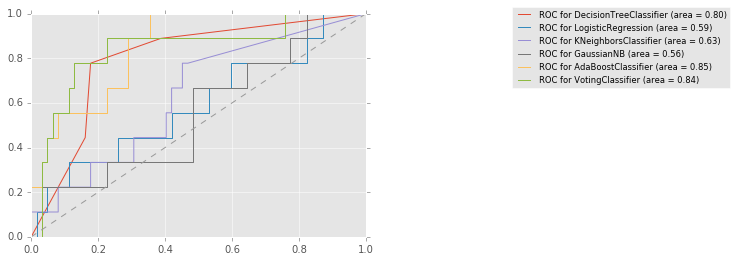

In [438]:
roc_curves = [dt_roc, lr_roc, knn_roc, nb_roc, ab_roc, vc_roc]

plot_roc_curves(roc_curves)

## Select best fit algorithm